In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Create directory to store plots.
if not os.path.exists('./img'):
    os.makedirs('./img')

In [3]:
# Seed for same randomness.
np.random.seed(seed=0)

In [4]:
class SimulatedAnnealing:
    def __init__(self, l, n_cities=12, grid_size=200, n_iter=1000) -> None:
        # Constant number of cities.
        self.n_cities = n_cities
        # Number of iterations for the markov chain.
        self.l = l
        # Size of the grid.
        self.GRID_SIZE = grid_size
        # Size of the diagonal.
        self.DIAGONAL = self.GRID_SIZE * math.sqrt(2)
        self.cities_coords = set()
        # Generate the random cities.
        self.generate_coordinates()
        # List to store the best of each iteration.
        self.best_historic = []

    def generate_coordinates(self):
        '''
        Function to generate a set of x, y coordinates that refer to the cities in the grid.
        '''
        # Generate random x, y coordinates for the cities in a 0, 100 range xy plane.
        while len(self.cities_coords) < self.n_cities:
            x, y = np.random.randint(0, self.GRID_SIZE), np.random.randint(0, self.GRID_SIZE)
            self.cities_coords.add((x, y))
        
        self.cities_coords = list(self.cities_coords)
        self.cities_coords = np.array(self.cities_coords)

    def plot_cities_map(self):
        '''
        Function for plotting the generated coordinates in a 2D map.
        '''
        # Get the X, Y arrays.
        x, y = self.cities_coords.T

        fig, ax = plt.subplots(figsize=(20, 12))

        ax.scatter(x, y)
        for i in range(len(self.cities_coords)):
            ax.annotate('City {}'.format(i), (x[i], y[i]))
        ax.set_title('2D Map of the cities')
        ax.figure.savefig('./img/{}.png'.format('2d_map'))

    def normalized_dist(self, x1, x2, y1, y2) -> float:
        '''
        Function for obtaining the normalized distance between two cities.
        '''
        return math.sqrt((x2-x1)**2 + (y2-y1)**2) / (self.DIAGONAL + 1)

    def calculate_cost(self, u) -> float:
        '''
        Function to calculate the cost to reach every city once starting and finishing from destination.
        '''
        total_distance = 0.0
        
        # Iterate over each pair of cities sequentially, getting their euclidean distance and adding it into the total.
        for i in range(1, self.n_cities):
            x1, y1 = u[i-1][0], u[i-1][1]
            x2, y2 = u[i][0], u[i][1]
            traverse_segment = self.normalized_dist(x1, x2, y1, y2)
            total_distance += traverse_segment

        # Get the last segment that would be the last city to the origin one.
        x1, y1 = u[self.n_cities-1][0], u[self.n_cities-1][1]
        x2, y2 = u[0][0], u[0][1]
        last_segment = self.normalized_dist(x1, x2, y1, y2)
        total_distance += last_segment

        return total_distance

    def generate_neighbor(self, u):
        '''
        Function to generate a new neighbor swapping two random cities in the order to visit.
        '''
        n0 = np.random.randint(0, self.n_cities - 1)
        n1 = np.random.randint(0, self.n_cities - 1)
        
        # Check that the city swap is not the same for n0 and n1.
        while n1 == n0:
            n1 = np.random.randint(0, self.n_cities - 1)

        # Make a copy for doing the swap and return.
        v = np.copy(u)
        v[[n0, n1]] = v[[n1, n0]]

        return v

    def markov_chain(self, u, temp_k):
        '''
        Markov chain used for the simulated annealing.
        '''
        accepted = 0

        # Iterate over a l value.
        for _ in range(self.l):
            # Generate the neighbor and calculate the costs.
            v = self.generate_neighbor(u)
            cost_u, cost_v = self.calculate_cost(u), self.calculate_cost(v)
            
            # For the case that the cost of neighbor is less than actual one or the metropolis algorithm evaluation is greater than an
            # arbitrary random probability, then replace it.
            if cost_v < cost_u:
                u = v
                accepted += 1
            elif np.random.uniform(0, 1) < np.exp(-(cost_v - cost_u)/temp_k):
                u = v
                accepted += 1

        # Return the replaced and the percentage of accepteds.
        return u, float(accepted/self.l)

    def initialize_temp(self, tk=0.1, rmin=0.9, beta=1.1):
        '''
        Initialize the temperature increasing it while the acceptation is lower than a threshold.
        '''
        u = self.cities_coords
        ra = 0
        
        # Iterate until the acceptation percentage reached the threshold.
        while (ra < rmin):
            u, ra = self.markov_chain(u, tk)
            tk *= beta

        return tk

    def simulated_annealing(self, n_iter=1000, alpha=0.995):
        '''
        Simulated annealing is going to run markov chain n iterations and then return the last path generated and
        the best historical.
        '''
        print('Initializating.')
        tk = self.initialize_temp()
        print('Initialization done.')
        k = 0
        u = self.cities_coords

        while k <= n_iter:
            if k % 100 == 0: print('Iteration: {}'.format(k))
            u, _ = self.markov_chain(u, tk)
            k += 1
            tk *= alpha
            self.best_historic.append(self.calculate_cost(u))

        return u, self.best_historic

    def plot_best_historic(self):
        '''
        Plot the best found curve for the iterations of the simulated annealing algorithm.
        '''
        plt.figure(figsize=(20, 12))
        plt.title('Best found curve using simulated annealing algorithm')
        plt.xlabel('Iteration')
        plt.ylabel('Total distance')
        best_historic = np.multiply(self.best_historic, self.DIAGONAL + 1)
        plt.plot(best_historic)
        plt.savefig('./img/{}.png'.format('best_historic_curve'))
        plt.show()

In [5]:
simulation = SimulatedAnnealing(100)
simulation.simulated_annealing()

Initializating.
Initialization done.
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000


(array([[ 87,  70],
        [ 21,  36],
        [ 25,  77],
        [ 39,  87],
        [ 88, 140],
        [ 81, 165],
        [ 67, 195],
        [ 58, 193],
        [117, 192],
        [174,  88],
        [172,  47],
        [103,   9]]),
 [4.821948734283975,
  3.6666637346764483,
  3.5695274315856578,
  5.204417003340409,
  4.324691474207622,
  4.104810792905554,
  4.764170068335659,
  5.197690375059028,
  4.929065391746739,
  5.1393743373657905,
  5.413470825146228,
  4.227927629500709,
  4.520393829111345,
  3.4054622994419703,
  5.237495493897658,
  4.509269722190014,
  3.9343969602380042,
  3.8158638928368385,
  4.405735470897496,
  4.279511454059839,
  5.111097107382145,
  4.30853348412448,
  4.470363306154877,
  4.408203744849901,
  3.639899368277035,
  3.9447366713178993,
  4.93940920736808,
  4.612861061344686,
  3.341154468275632,
  3.3905907046013253,
  3.55805942996293,
  3.839844168312928,
  4.524962289681115,
  4.566454819334302,
  4.0673131466235075,
  4.7709099277859

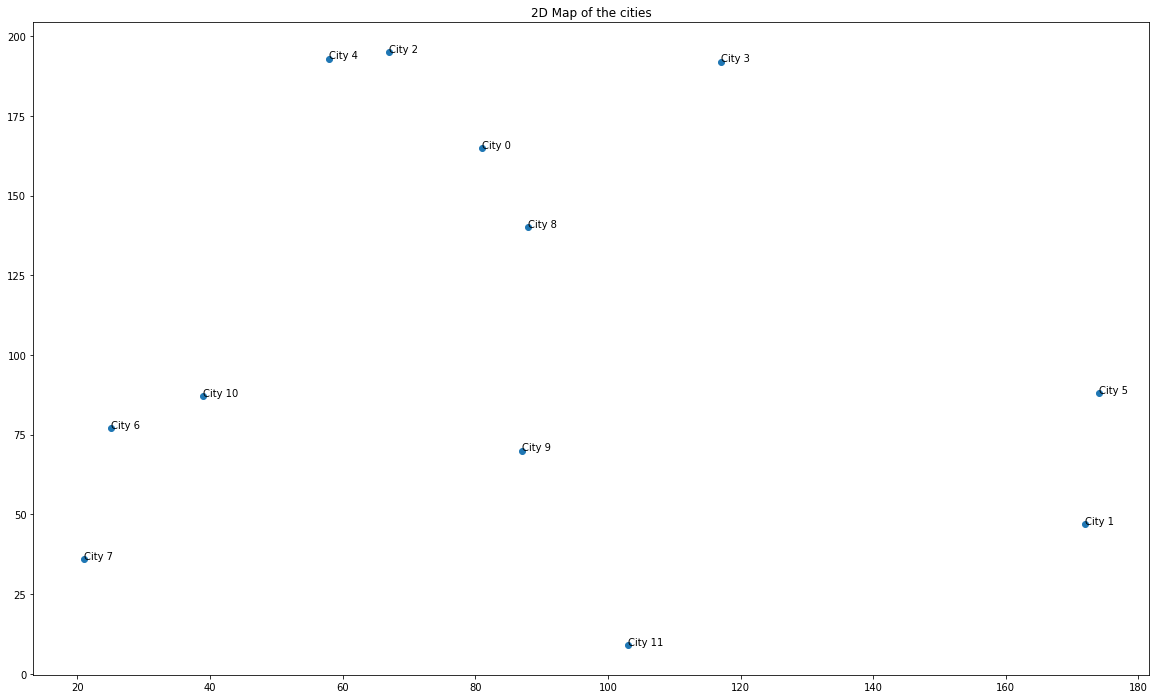

In [6]:
simulation.plot_cities_map()

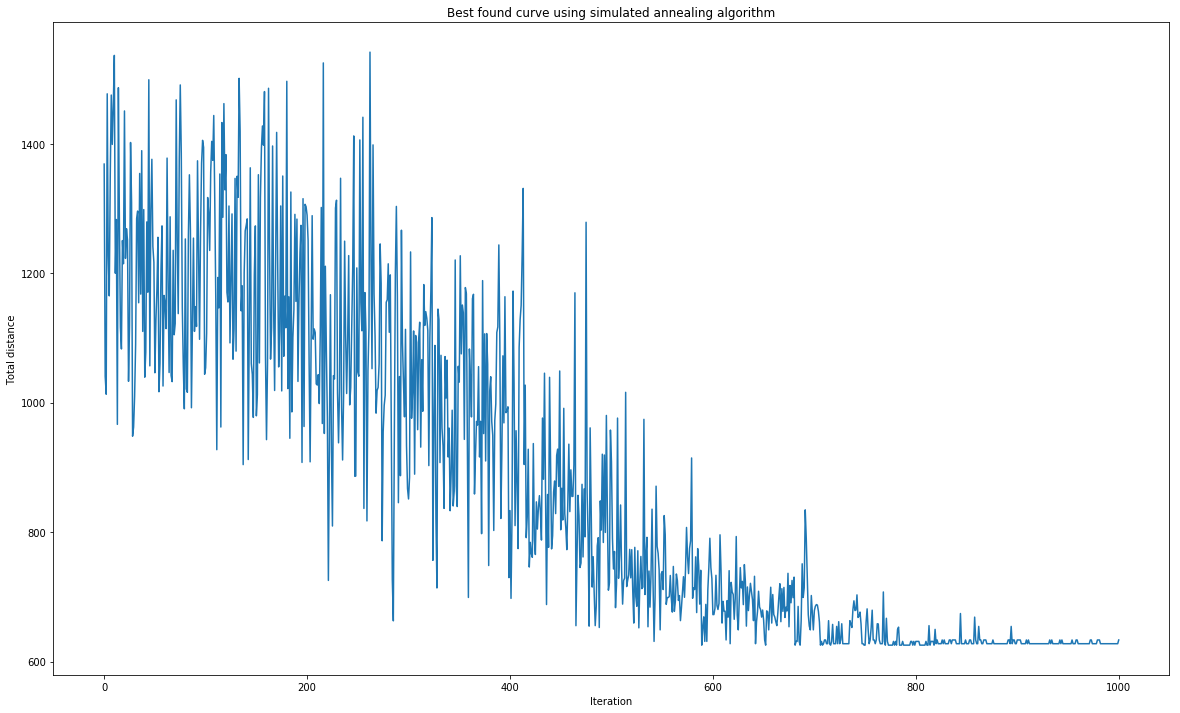

In [7]:
simulation.plot_best_historic()